### Develop analyses to look at weights of pseudo population decoders

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
import utils.pseudo_utils as pseudo_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils

from utils.session_data import SessionData
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from trial_splitters.kfold_splitter import KFoldSplitter
from trial_splitters.rule_condition_block_splitter import RuleConditionBlockSplitter
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter
from trial_splitters.dummy_pseudo_splitter import DummyPseudoSplitter
from trial_splitters.condition_kfold_block_splitter import ConditionKFoldBlockSplitter

from models.value_models import ValueNormedModel, ValueNormedDropoutModel
import pickle

from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression

from models.trainer import Trainer
from sklearn.cluster import KMeans

import torch
from torch import nn

import plotly.express as px
import matplotlib.patches as patches

import scipy.stats as sci_stats
import scipy

from itertools import accumulate

PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 100
EVENT = "FeedbackOnset"

import os
import json

### Look at positions of all the neurons first, group and color by level 1 structure, plot without and with unidentified neurons. 

In [2]:
def get_neuron_positions(row):
    session = row.session_name
    # For the cases like 201807250001
    sess_day = session[:8]
    info_path = f"/data/rawdata/sub-SA/sess-{sess_day}/session_info/sub-SA_sess-{sess_day}_sessioninfo.json"
    frs = pd.read_pickle(f"/data/patrick_scratch/multi_sess/{session}/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins.pickle")
    with open(info_path, 'r') as f:
        data = json.load(f)
    locs = data['electrode_info']
    locs_df = pd.DataFrame.from_dict(locs)
    # TODO: filter by units appearing in firing rates file. 
    electrode_pos_not_nan = locs_df[~locs_df['x'].isna() & ~locs_df['y'].isna() & ~locs_df['z'].isna()]
    units = spike_general.list_session_units(None, "SA", session, species_dir="/data")
    unit_pos = pd.merge(units, electrode_pos_not_nan, left_on="Channel", right_on="electrode_id", how="left")
    unit_pos = unit_pos.astype({"UnitID": int})
    unit_pos["session"] = session
    unit_pos = unit_pos[unit_pos.UnitID.isin(frs.UnitID.unique())]
    unit_pos["PseudoUnitID"] = int(session) * 100 + unit_pos["UnitID"]
    return unit_pos

valid_sess = pd.read_pickle("/data/patrick_scratch/multi_sess/valid_sessions.pickle")
positions = pd.concat(valid_sess.apply(get_neuron_positions, axis=1).values)
# known_poses = positions.structure_level1.dropna().unique()
# sort that so its always in order
# still want to plot the None units
positions.structure_level1 = positions.structure_level1.fillna("unknown")
structure_names = positions.structure_level1.unique()
structure_names.sort()


In [3]:
session = "20180802"
frs = pd.read_pickle(f"/data/patrick_scratch/multi_sess/{session}/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins.pickle")

In [4]:
frs

,TrialNumber,UnitID,TimeBins,SpikeCounts,FiringRate
0,0.0,0,0.0,0.0,0.0
1,0.0,0,0.1,0.0,0.0
2,0.0,0,0.2,0.0,0.0
3,0.0,0,0.3,0.0,0.0
4,0.0,0,0.4,0.0,0.0
...,...,...,...,...,...
2252707,1749.0,45,2.3,0.0,0.0
2252708,1749.0,45,2.4,0.0,0.0
2252709,1749.0,45,2.5,0.0,0.0
2252710,1749.0,45,2.6,0.0,0.0


In [3]:
pos_unit_sorted = positions.sort_values(by="PseudoUnitID")
pos_unit_sorted["np_idx"] = np.arange(0, len(pos_unit_sorted))
pos_structure_sorted = pos_unit_sorted.sort_values(by="structure_level1")
reordered_idxs = pos_structure_sorted.np_idx.values

In [4]:
lens = pos_structure_sorted.groupby("structure_level1").apply(lambda x: len(x)).values

In [5]:
lens_accum = list(accumulate(lens))
reg_start = lens_accum[:-1].insert(0, 0)
reg_end = list(np.array(lens_accum[1:]) - 1)
lines = np.array(lens_accum[0:-1]) - 0.5

In [6]:
lines

array([274.5, 280.5, 357.5, 422.5, 442.5, 666.5])

In [7]:
name_to_color = {}
hexes_tab10 = [matplotlib.colors.to_hex(x) for x in plt.cm.tab10.colors]
for i, pos in enumerate(structure_names):
    print(pos)
    print(i)
    name_to_color[pos] = hexes_tab10[i]
# add a grey for unknown
name_to_color["unknown"] = "#adadad"

Frontal_Lobe (Frontal)
0
Occipital_Lobe (Occipital)
1
Parietal_Lobe (Parietal)
2
Temporal_Lobe (Temporal)
3
diencephalon (di)
4
telencephalon (tel)
5
unknown
6


### See if adding to a glass brain works

In [8]:
fig1 = px.scatter_3d(
    positions, x="x", y="y", z="z", 
    color="structure_level1", 
    labels={"structure_level1": "Structure"},
    color_discrete_map=name_to_color)
fig = visualization_utils.plotly_add_glass_brain(None, fig1, "SA", areas='all', show_axis=False)
fig.update_layout(
    autosize=True,
    width=750,
    height=700,
)
camera = dict(
    eye=dict(x=1.3, y=1, z=0.1)
)
temp_grid = dict(
    showgrid=False, 
    zeroline=False, 
    showticklabels=False
)
fig.update_layout(
    autosize=False,
    width=1000,
    height=700,
    xaxis=temp_grid,
    yaxis=temp_grid,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=True,
    scene_camera=camera
)
fig.write_html("/data/patrick_scratch/pseudo/figs/units_glass_brain.html")

### See if plotting weights makes sense here

In [9]:
# load some models
base_dir = "/data/patrick_scratch/pseudo"
# feature_dim = "Pattern"
# models = np.load(os.path.join(base_dir, f"{feature_dim}_models.npy"), allow_pickle=True)
models = np.load(os.path.join(base_dir, f"block_position_cor_fb_models.npy"), allow_pickle=True)

In [10]:
weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 1117, 2)
sums = np.sum(weights, axis=0)
normalized = weights / sums


[274.5 280.5 357.5 422.5 442.5 666.5]
8


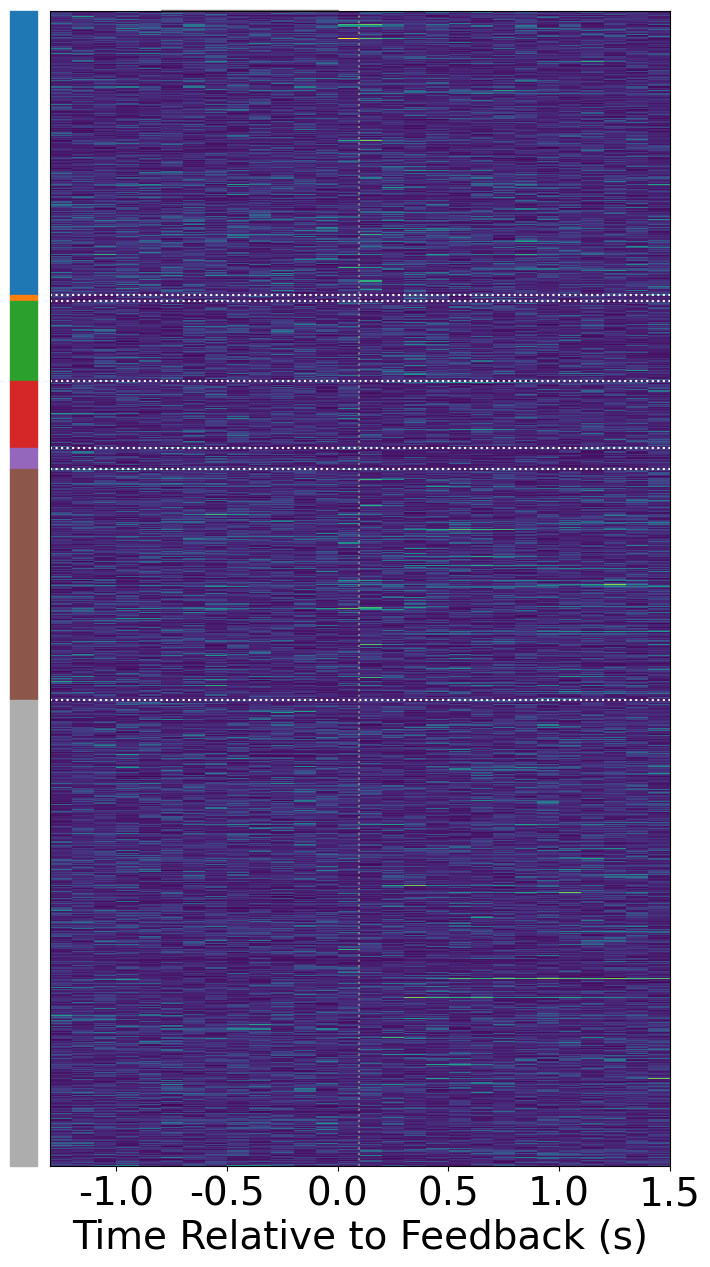

In [11]:
# models are num_time_points x num_models
matplotlib.rcParams.update({'font.size': 28})

# reorder by temp then ant
reordered = normalized[reordered_idxs, :]


fig, ax = plt.subplots(figsize=(8, 15))
colors = ax.matshow(reordered, aspect='auto')
# tick_labels = np.array([-1.2, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1.2])
tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
tick_pos = (tick_labels + 1.3) * 10 - 0.5
# fig.colorbar(colors)
# axis = np.arange(0, 28, 3)s
# labels = np.around((axis - 13) * 0.1, 1)
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_xlabel("Time Relative to Feedback (s)")
ax.get_yaxis().set_visible(False)
ax.set_ylabel([])
# y_axis = np.arange(0, 59, 5)
# ax.set_yticks(y_axis)
# ax.set_yticklabels(y_axis)

boundaries = np.insert(np.insert(lines, len(lines), reordered.shape[0] - 0.5), 0, -0.5)
print(lines)
print(len(boundaries))
for line in lines:
    ax.axhline(line, color='white', linestyle="dotted")

for i in range(len(boundaries)-1):
    structure_name = structure_names[i]
    rect = patches.Rectangle(
        (
            -1.3 - 1,
            (boundaries[i])#+boundaries[i+1]) / 2
        ),
        1.2,
        (boundaries[i+1]-boundaries[i]),
        edgecolor=name_to_color[structure_name],
        facecolor=name_to_color[structure_name],
        clip_on=False
    )
    ax.add_patch(rect)
gray_rect = patches.Rectangle(
    (4.5, -1.2), 8, 0.5,
    edgecolor="gray",
    facecolor="gray",
    clip_on=False,
)
ax.add_patch(gray_rect)
ax.axvline(13.48, color="gray", linestyle="dotted")


## Visualize weights, sorted in each region by magnitude of weight at a certain time point

In [31]:
weights_at_time_14 = weights[:, 14]
weights_at_time_19 = weights[:, 19]

In [32]:
pos_unit_sorted["weight_at_time_14"] = weights_at_time_14
pos_unit_sorted["weight_at_time_19"] = weights_at_time_19

In [35]:
pos_structure_weight_sorted = pos_unit_sorted.sort_values(by=["structure_level1", "weight_at_time_19"], ascending=[True, False])

In [36]:
reordered_idxs = pos_structure_weight_sorted.np_idx.values

[274.5 280.5 357.5 422.5 442.5 666.5]
8


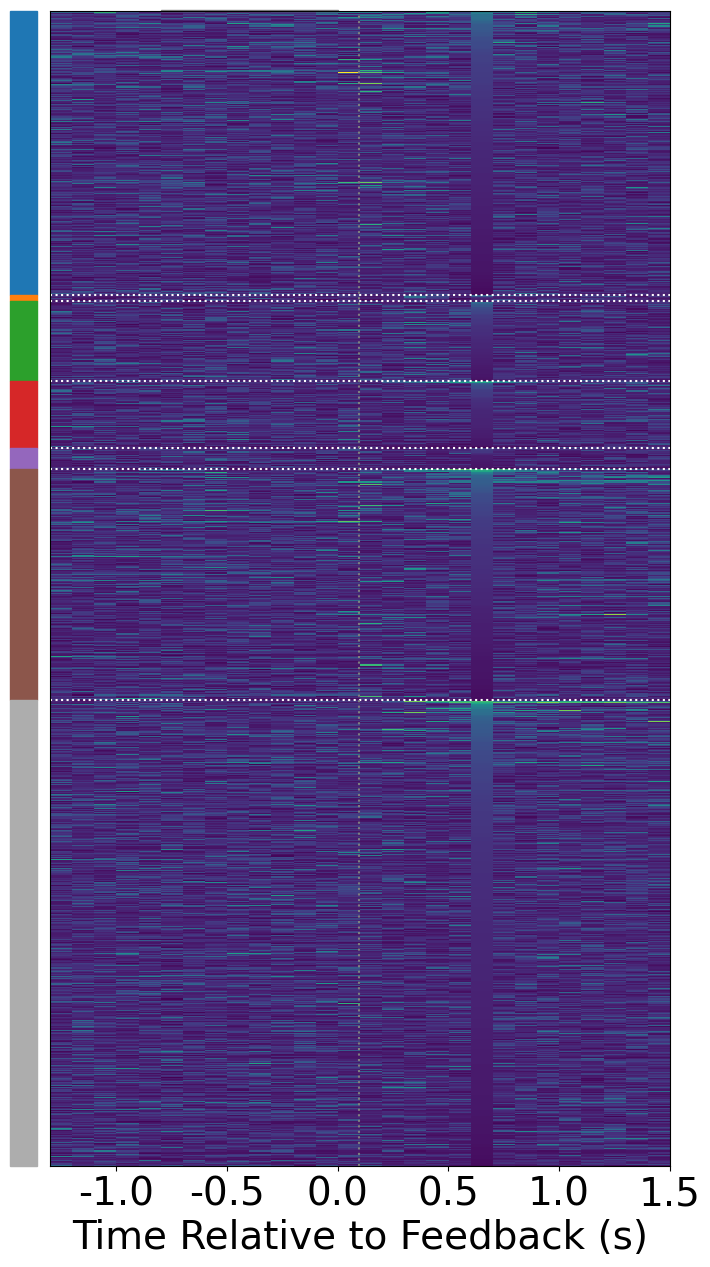

In [37]:
# models are num_time_points x num_models
matplotlib.rcParams.update({'font.size': 28})

# reorder by temp then ant
reordered = normalized[reordered_idxs, :]


fig, ax = plt.subplots(figsize=(8, 15))
colors = ax.matshow(reordered, aspect='auto')
# tick_labels = np.array([-1.2, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1.2])
tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
tick_pos = (tick_labels + 1.3) * 10 - 0.5
# fig.colorbar(colors)
# axis = np.arange(0, 28, 3)s
# labels = np.around((axis - 13) * 0.1, 1)
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_xlabel("Time Relative to Feedback (s)")
ax.get_yaxis().set_visible(False)
ax.set_ylabel([])
# y_axis = np.arange(0, 59, 5)
# ax.set_yticks(y_axis)
# ax.set_yticklabels(y_axis)

boundaries = np.insert(np.insert(lines, len(lines), reordered.shape[0] - 0.5), 0, -0.5)
print(lines)
print(len(boundaries))
for line in lines:
    ax.axhline(line, color='white', linestyle="dotted")

for i in range(len(boundaries)-1):
    structure_name = structure_names[i]
    rect = patches.Rectangle(
        (
            -1.3 - 1,
            (boundaries[i])#+boundaries[i+1]) / 2
        ),
        1.2,
        (boundaries[i+1]-boundaries[i]),
        edgecolor=name_to_color[structure_name],
        facecolor=name_to_color[structure_name],
        clip_on=False
    )
    ax.add_patch(rect)
gray_rect = patches.Rectangle(
    (4.5, -1.2), 8, 0.5,
    edgecolor="gray",
    facecolor="gray",
    clip_on=False,
)
ax.add_patch(gray_rect)
ax.axvline(13.48, color="gray", linestyle="dotted")


(array([262., 508., 201.,  87.,  28.,  16.,   7.,   1.,   5.,   2.]),
 array([0.00710447, 0.0218088 , 0.03651313, 0.05121746, 0.06592179,
        0.08062612, 0.09533045, 0.11003478, 0.12473911, 0.13944344,
        0.15414777]),
 <BarContainer object of 10 artists>)

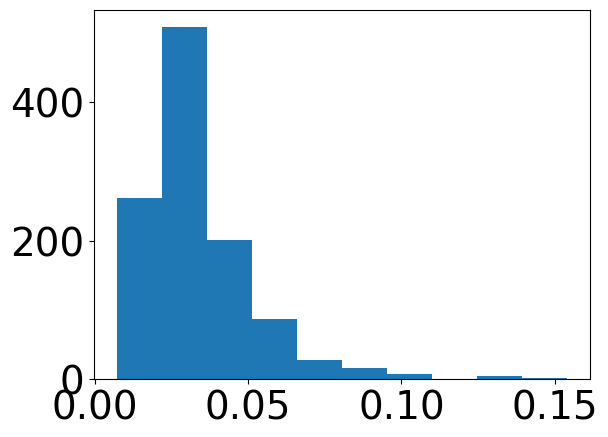

In [39]:
plt.hist(pos_structure_weight_sorted.weight_at_time_19)

In [45]:
pos_structure_weight_sorted.columns

Index(['UnitID', 'Channel', 'Unit', 'SpikeTimesFile', 'electrode_id', 'x', 'y',
       'z', 'distance', 'in_brain', 'tissue', 'structure_level1',
       'structure_level2', 'structure_level3', 'structure_level4',
       'structure_level5', 'structure_level6', 'structure_potential',
       'session', 'PseudoUnitID', 'np_idx', 'weight_at_time',
       'weight_at_time_14', 'weight_at_time_19'],
      dtype='object')

In [50]:
pos_structure_weight_sorted[pos_structure_weight_sorted.weight_at_time_14 > 0.1][["UnitID", "Channel", "structure_level2", "session", "weight_at_time_14"]].sort_values("weight_at_time_14")

,UnitID,Channel,structure_level2,session,weight_at_time_14
32,32,22a,None,20180615,0.101447
0,0,13a,anterior_cingulate_gyrus (ACgG),20180830,0.102542
2,2,75,basal_ganglia (BG),20180817,0.107958
12,12,98,basal_ganglia (BG),20180705,0.116089
23,23,13a,anterior_cingulate_gyrus (ACgG),20180905,0.116099
21,21,13a,anterior_cingulate_gyrus (ACgG),20180910,0.116601
48,48,98,basal_ganglia (BG),20180712,0.129493
8,8,75,basal_ganglia (BG),20180904,0.133797
22,22,13a,anterior_cingulate_gyrus (ACgG),20180907,0.135534
27,27,27a,lateral_prefrontal_cortex (lat_PFC),20180622,0.137724


In [49]:
pos_structure_weight_sorted[pos_structure_weight_sorted.weight_at_time_19 > 0.1].sort_values("weight_at_time_19")[["UnitID", "Channel", "structure_level2", "session", "weight_at_time_19"]]

,UnitID,Channel,structure_level2,session,weight_at_time_19
7,7,53,None,20180625,0.100781
18,18,83,basal_ganglia (BG),20180615,0.101228
11,11,96a,motor_cortex (motor),20180806,0.101476
23,23,2,None,20180925,0.103602
20,20,53,None,20180625,0.108936
18,18,122,inferior_temporal_cortex (ITC),20180907,0.123512
25,25,122,inferior_temporal_cortex (ITC),20180911,0.126928
41,41,52a,None,20180801,0.130455
3,3,90,amygdala (Amy),20180906,0.130630
6,6,90,amygdala (Amy),20180912,0.135567
